**Imports** (Set your directory to the folder "APS360_Project" here). This will be used throughout the rest of the notebook.

In [ ]:
path_to_APS360_Project = "/content/drive/MyDrive/"


In [ ]:
import torch
import numpy as np


import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torch.utils import data

from skimage.io import imread
import os

import time
import matplotlib.pyplot as plt

from PIL import Image
import albumentations as A
import random
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset Class To load segmentation images and mask based on data ID

In [ ]:
class SegmentationDataSet(data.Dataset):
    def __init__(self,
                 inputs: list,
                 images_root, 
                 targets_root,
                 resize_to,
                 transform=None                 
                 ):
        self.inputs = inputs
        self.images_root = images_root
        self.targets_root = targets_root
        self.transform = transform
        self.resize_to = resize_to

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,
                    index: int):
        # Select the sample
        input_ID = self.inputs[index]
        img_path = os.path.join(self.images_root, input_ID) 
        img = cv2.imread(img_path,  cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.resize_to, self.resize_to)) 
        #reads in image, resize to desired target size

        mask_path = os.path.join(self.targets_root, input_ID) 
        mask = cv2.imread(mask_path,  cv2.IMREAD_GRAYSCALE)#Image.open(mask_path).convert("L") #grayscale
        mask = cv2.resize(mask, (self.resize_to,self.resize_to))

        # Preprocessing with on-the-fly data augmentations
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = aug["image"]
            mask = aug["mask"]
           # print(img.shape)
            
        img = torch.tensor(img).unsqueeze(0)
        mask = torch.tensor(mask).unsqueeze(0)
        img = img/255
        mask = mask/255 #to normalize
       
        return img, mask, input_ID

In [ ]:
# pwd = os.getcwd()

**The following is for data preprocessing into train, valid- and test splits. The horizontal and Vertical Flips along with rotations are applied to expland the nuber of training images from 388 to 2328. This part is only run once. Skip until the next boldface message (the following cells are only meant to be run once)**

In [ ]:
inps = os.listdir(os.path.join(path_to_APS360_Project, "APS360_Project/Dataset/t_image"))
len(inps)

647

In [ ]:
random.seed(11)

torch.manual_seed(0)
img_root = os.path.join(path_to_APS360_Project, "APS360_Project/Dataset/t_image") 
mask_root = os.path.join(path_to_APS360_Project,"APS360_Project/Dataset/t_masked") 


In [ ]:
train_size = int( 0.6 * len(inps)) #get size of train set
valid_size = int(0.2 * len(inps))
test_size = len(inps) - train_size - valid_size
random.shuffle(inps)
train_inps = inps[:train_size]
valid_inps = inps[train_size:train_size + valid_size]
test_inps = inps[train_size + valid_size:]
print("train set has size: ", len(train_inps))
print("valid set has size: ", len(valid_inps))
print("test set has size: ", len(test_inps))

In [ ]:
train_inps

['135.png',
 '492.png',
 '513.png',
 '428.png',
 '546.png',
 '84.png',
 '160.png',
 '106.png',
 '329.png',
 '259.png',
 '98.png',
 '588.png',
 '386.png',
 '438.png',
 '437.png',
 '622.png',
 '152.png',
 '14.png',
 '113.png',
 '58.png',
 '285.png',
 '608.png',
 '473.png',
 '224.png',
 '561.png',
 '28.png',
 '168.png',
 '257.png',
 '381.png',
 '431.png',
 '418.png',
 '447.png',
 '506.png',
 '193.png',
 '517.png',
 '474.png',
 '426.png',
 '341.png',
 '484.png',
 '629.png',
 '422.png',
 '94.png',
 '626.png',
 '343.png',
 '528.png',
 '268.png',
 '389.png',
 '631.png',
 '240.png',
 '390.png',
 '550.png',
 '549.png',
 '589.png',
 '282.png',
 '210.png',
 '369.png',
 '540.png',
 '50.png',
 '423.png',
 '258.png',
 '620.png',
 '407.png',
 '290.png',
 '536.png',
 '607.png',
 '569.png',
 '207.png',
 '146.png',
 '455.png',
 '483.png',
 '397.png',
 '504.png',
 '253.png',
 '490.png',
 '88.png',
 '559.png',
 '537.png',
 '364.png',
 '574.png',
 '552.png',
 '529.png',
 '272.png',
 '522.png',
 '581.png',


In [ ]:
for input_ID in train_inps:
  print(input_ID)

In [ ]:
for input_ID in train_inps:
  # input_ID = train_inps[0]
  idx = input_ID.split('.')[0] 
  img_path = os.path.join(img_root, input_ID) #may need to add in .png at end
  img_1 = cv2.imread(img_path,  cv2.IMREAD_GRAYSCALE)

  mask_path = os.path.join(mask_root, input_ID) 
  mask_1 = cv2.imread(mask_path,  cv2.IMREAD_GRAYSCALE)#Image.open(mask_path).convert("L") #grayscale

  cv2.imwrite("/content/drive/MyDrive/APS360_Project/Dataset_Expanded/Train/images/"+idx+"_1.png", img_1)
  cv2.imwrite("/content/drive/MyDrive/APS360_Project/Dataset_Expanded/Train/masks/"+idx+"_1.png", mask_1)

  aug1 = A.HorizontalFlip(p=1.0)
  aug = aug1(image=img_1, mask=mask_1)
  img_2 = aug["image"]
  mask_2 = aug["mask"]
  cv2.imwrite("/content/drive/MyDrive/APS360_Project/Dataset_Expanded/Train/images/"+idx+"_2.png", img_2)
  cv2.imwrite("/content/drive/MyDrive/APS360_Project/Dataset_Expanded/Train/masks/"+idx+"_2.png", mask_2)

  aug2 = A.VerticalFlip(p=1.0)
  aug = aug2(image=img_1, mask=mask_1)
  img_3 = aug["image"]
  mask_3 = aug["mask"]

  cv2.imwrite("/content/drive/MyDrive/APS360_Project/Dataset_Expanded/Train/images/"+idx+"_3.png", img_3)
  cv2.imwrite("/content/drive/MyDrive/APS360_Project/Dataset_Expanded/Train/masks/"+idx+"_3.png", mask_3)


  img_4 = cv2.rotate(img_1, cv2.ROTATE_90_CLOCKWISE)
  mask_4 = cv2.rotate(mask_1, cv2.ROTATE_90_CLOCKWISE)
  cv2.imwrite("/content/drive/MyDrive/APS360_Project/Dataset_Expanded/Train/images/"+idx+"_4.png", img_4)
  cv2.imwrite("/content/drive/MyDrive/APS360_Project/Dataset_Expanded/Train/masks/"+idx+"_4.png", mask_4)


  img_5 = cv2.rotate(img_1, cv2.ROTATE_90_COUNTERCLOCKWISE)
  mask_5 = cv2.rotate(mask_1, cv2.ROTATE_90_COUNTERCLOCKWISE)
  cv2.imwrite("/content/drive/MyDrive/APS360_Project/Dataset_Expanded/Train/images/"+idx+"_5.png", img_5)
  cv2.imwrite("/content/drive/MyDrive/APS360_Project/Dataset_Expanded/Train/masks/"+idx+"_5.png", mask_5)

  img_6 = cv2.rotate(img_1, cv2.ROTATE_180)
  mask_6 = cv2.rotate(mask_1, cv2.ROTATE_180)
  cv2.imwrite("/content/drive/MyDrive/APS360_Project/Dataset_Expanded/Train/images/"+idx+"_6.png", img_6)
  cv2.imwrite("/content/drive/MyDrive/APS360_Project/Dataset_Expanded/Train/masks/"+idx+"_6.png", mask_6)
  

  # f, axis = plt.subplots(nrows=6, ncols=2, constrained_layout=True, figsize=(10, 10))

  # axis[0,0].imshow(img_1, cmap='gray')
  # axis[0,1].imshow(mask_1, cmap='gray')

  # axis[1,0].imshow(img_2, cmap='gray')
  # axis[1,1].imshow(mask_2, cmap='gray')

  # axis[2,0].imshow(img_3, cmap='gray')
  # axis[2,1].imshow(mask_3, cmap='gray')

  # axis[3,0].imshow(img_4, cmap='gray')
  # axis[3,1].imshow(mask_4, cmap='gray')

  # axis[4,0].imshow(img_5, cmap='gray')
  # axis[4,1].imshow(mask_5, cmap='gray')

  # axis[5,0].imshow(img_6, cmap='gray')
  # axis[5,1].imshow(mask_6, cmap='gray')

  # plt.show()

In [ ]:
expanded_train_imgs = os.listdir(os.path.join(path_to_APS360_Project, "APS360_Project/Dataset_Expanded/Train/images"))
expanded_train_masks = os.listdir(os.path.join(path_to_APS360_Project, "APS360_Project/Dataset_Expanded/Train/masks"))

print(len(expanded_train_imgs))
print(len(expanded_train_masks))


2328
2328


In [ ]:
len(valid_inps)

129

In [ ]:
for input_ID in valid_inps:
  # input_ID = train_inps[0]
  idx = input_ID.split('.')[0] 
  img_path = os.path.join(img_root, input_ID) #may need to add in .png at end
  img_1 = cv2.imread(img_path,  cv2.IMREAD_GRAYSCALE)

  mask_path = os.path.join(mask_root, input_ID) 
  mask_1 = cv2.imread(mask_path,  cv2.IMREAD_GRAYSCALE)#Image.open(mask_path).convert("L") #grayscale

  cv2.imwrite("/content/drive/MyDrive/APS360_Project/Dataset_Expanded/Valid/images/"+input_ID, img_1)
  cv2.imwrite("/content/drive/MyDrive/APS360_Project/Dataset_Expanded/Valid/masks/"+input_ID, mask_1)

In [ ]:
expanded_valid_imgs = os.listdir(os.path.join(path_to_APS360_Project, "APS360_Project/Dataset_Expanded/Valid/images"))
expanded_valid_masks = os.listdir(os.path.join(path_to_APS360_Project, "APS360_Project/Dataset_Expanded/Valid/masks"))

print(len(expanded_valid_imgs))
print(len(expanded_valid_masks))


129
129


In [ ]:
os.listdir(os.path.join(path_to_APS360_Project, "APS360_Project/Dataset_Expanded/Valid/images"))

['619.png',
 '544.png',
 '6.png',
 '298.png',
 '606.png',
 '554.png',
 '339.png',
 '319.png',
 '7.png',
 '293.png',
 '512.png',
 '638.png',
 '526.png',
 '39.png',
 '242.png',
 '350.png',
 '538.png',
 '180.png',
 '174.png',
 '577.png',
 '66.png',
 '488.png',
 '411.png',
 '413.png',
 '22.png',
 '523.png',
 '501.png',
 '279.png',
 '231.png',
 '425.png',
 '466.png',
 '69.png',
 '162.png',
 '548.png',
 '374.png',
 '34.png',
 '246.png',
 '38.png',
 '325.png',
 '306.png',
 '10.png',
 '435.png',
 '159.png',
 '358.png',
 '183.png',
 '243.png',
 '533.png',
 '584.png',
 '302.png',
 '592.png',
 '299.png',
 '267.png',
 '353.png',
 '375.png',
 '532.png',
 '169.png',
 '230.png',
 '70.png',
 '186.png',
 '47.png',
 '67.png',
 '292.png',
 '271.png',
 '188.png',
 '144.png',
 '90.png',
 '23.png',
 '593.png',
 '127.png',
 '228.png',
 '209.png',
 '565.png',
 '477.png',
 '8.png',
 '383.png',
 '104.png',
 '108.png',
 '143.png',
 '37.png',
 '314.png',
 '315.png',
 '436.png',
 '613.png',
 '286.png',
 '245.png',

In [ ]:
'102.png' in test_inps

True

In [ ]:
for input_ID in test_inps:
  # input_ID = train_inps[0]
  idx = input_ID.split('.')[0] 
  img_path = os.path.join(img_root, input_ID) #may need to add in .png at end
  img_1 = cv2.imread(img_path,  cv2.IMREAD_GRAYSCALE)

  mask_path = os.path.join(mask_root, input_ID) 
  mask_1 = cv2.imread(mask_path,  cv2.IMREAD_GRAYSCALE)#Image.open(mask_path).convert("L") #grayscale

  cv2.imwrite("/content/drive/MyDrive/APS360_Project/Dataset_Expanded/Test/images/"+input_ID, img_1)
  cv2.imwrite("/content/drive/MyDrive/APS360_Project/Dataset_Expanded/Test/masks/"+input_ID, mask_1)

In [ ]:
expanded_test_imgs = os.listdir(os.path.join(path_to_APS360_Project, "APS360_Project/Dataset_Expanded/Test/images"))
expanded_test_masks = os.listdir(os.path.join(path_to_APS360_Project, "APS360_Project/Dataset_Expanded/Test/masks"))

print(len(expanded_test_imgs))
print(len(expanded_test_masks))


130
130


**End of Data Preprocessing. You may continue running the cells from here.**

In [ ]:
train_img_root = os.path.join(path_to_APS360_Project, "APS360_Project/Dataset_Expanded/Fold2/Train/images")
train_mask_root = os.path.join(path_to_APS360_Project, "APS360_Project/Dataset_Expanded/Fold2/Train/masks")
train_inps = os.listdir(train_img_root)

valid_img_root = os.path.join(path_to_APS360_Project, "APS360_Project/Dataset_Expanded/Fold2/Valid/images")
valid_mask_root = os.path.join(path_to_APS360_Project, "APS360_Project/Dataset_Expanded/Fold2/Valid/masks")
valid_inps = os.listdir(valid_img_root) 

In [ ]:
#data augmentation to be aplied on training set on the fly
train_aug = A.Compose(
    [              
    A.RandomBrightnessContrast(p=0.5),    
    A.GaussNoise(p=0.5)
    ],
    )

In [ ]:
resized_to = 224
train_dset = SegmentationDataSet(train_inps, train_img_root, train_mask_root, resized_to, train_aug)
valid_dset = SegmentationDataSet(valid_inps,valid_img_root, valid_mask_root,resized_to,)

In [ ]:
print("Train set has: " , len(train_dset)) 
print("Validation set has: ", len(valid_dset))


To visualize some images

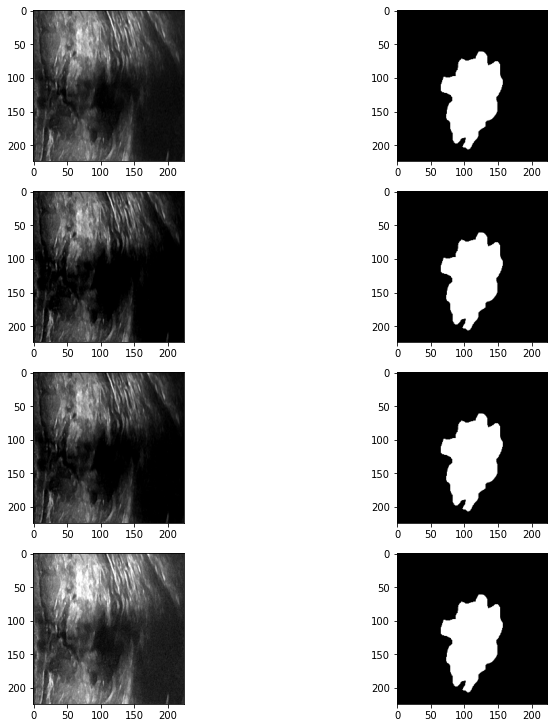

In [ ]:
# test if the albumentations is indeed providing the correct image-mask transformations by dusplaying four of the same image transformed
f, axis = plt.subplots(nrows=4, ncols=2, constrained_layout=True, figsize=(10, 10))

for i in range(4):
  mydata = train_dset[8]
  axis[i,0].imshow(mydata[0].squeeze() *255, cmap='gray')
  axis[i,1].imshow(mydata[1].squeeze() *255, cmap='gray')


plt.show()



In [ ]:
#define data loaders
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=10, 
                                           num_workers=4, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dset, batch_size=10, 
                                           num_workers=4, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**visualize training loader (optional. can skip to Model section)**

In [ ]:
x = next(iter(train_loader))

In [ ]:
x[0].shape

torch.Size([10, 1, 128, 128])

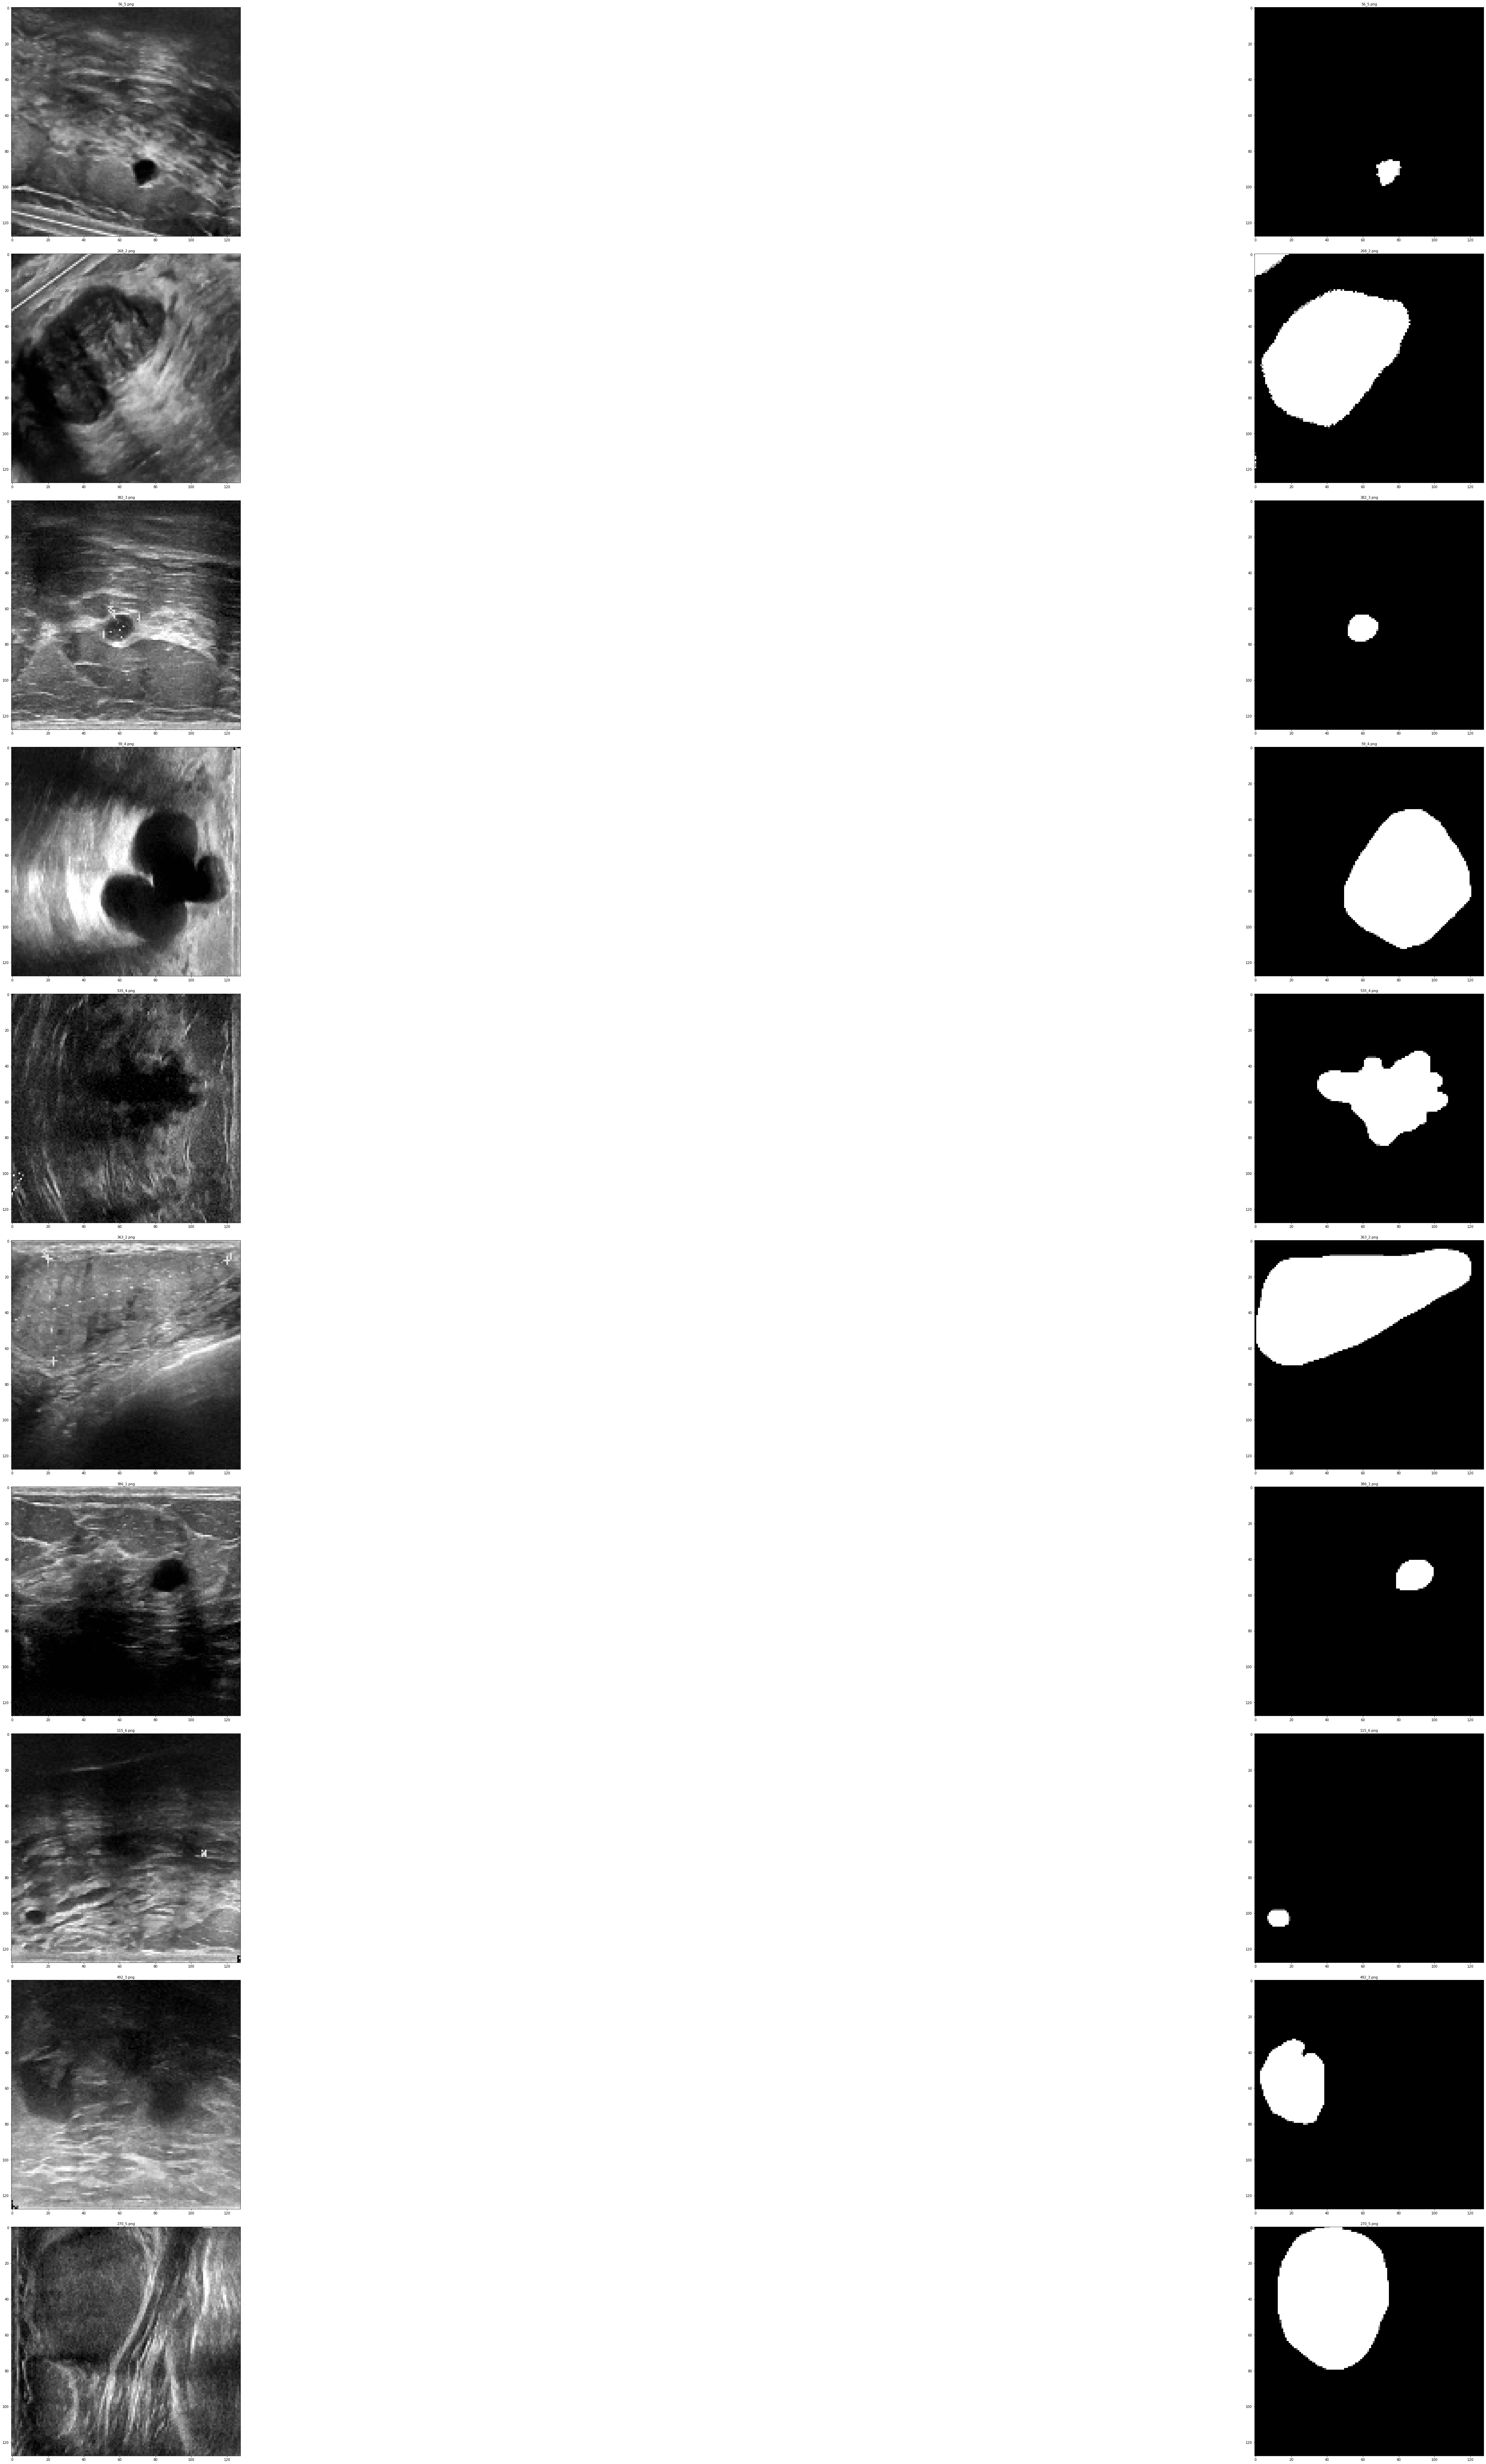

In [ ]:
#visualize first 10 elems in trainloader batch
f, axis = plt.subplots(nrows=10, ncols=2, constrained_layout=True, figsize=(100, 100))

for i in range(10):
  axis[i,0].set_title(x[2][i], fontsize='medium')
  axis[i,0].imshow(x[0][i].squeeze() *255, cmap='gray')
  axis[i,1].set_title(x[2][i],fontsize='medium')
  axis[i,1].imshow(x[1][i].squeeze() *255, cmap='gray')

plt.show()


**visualize validation loader (optional)**

In [ ]:
v = next(iter(valid_loader))

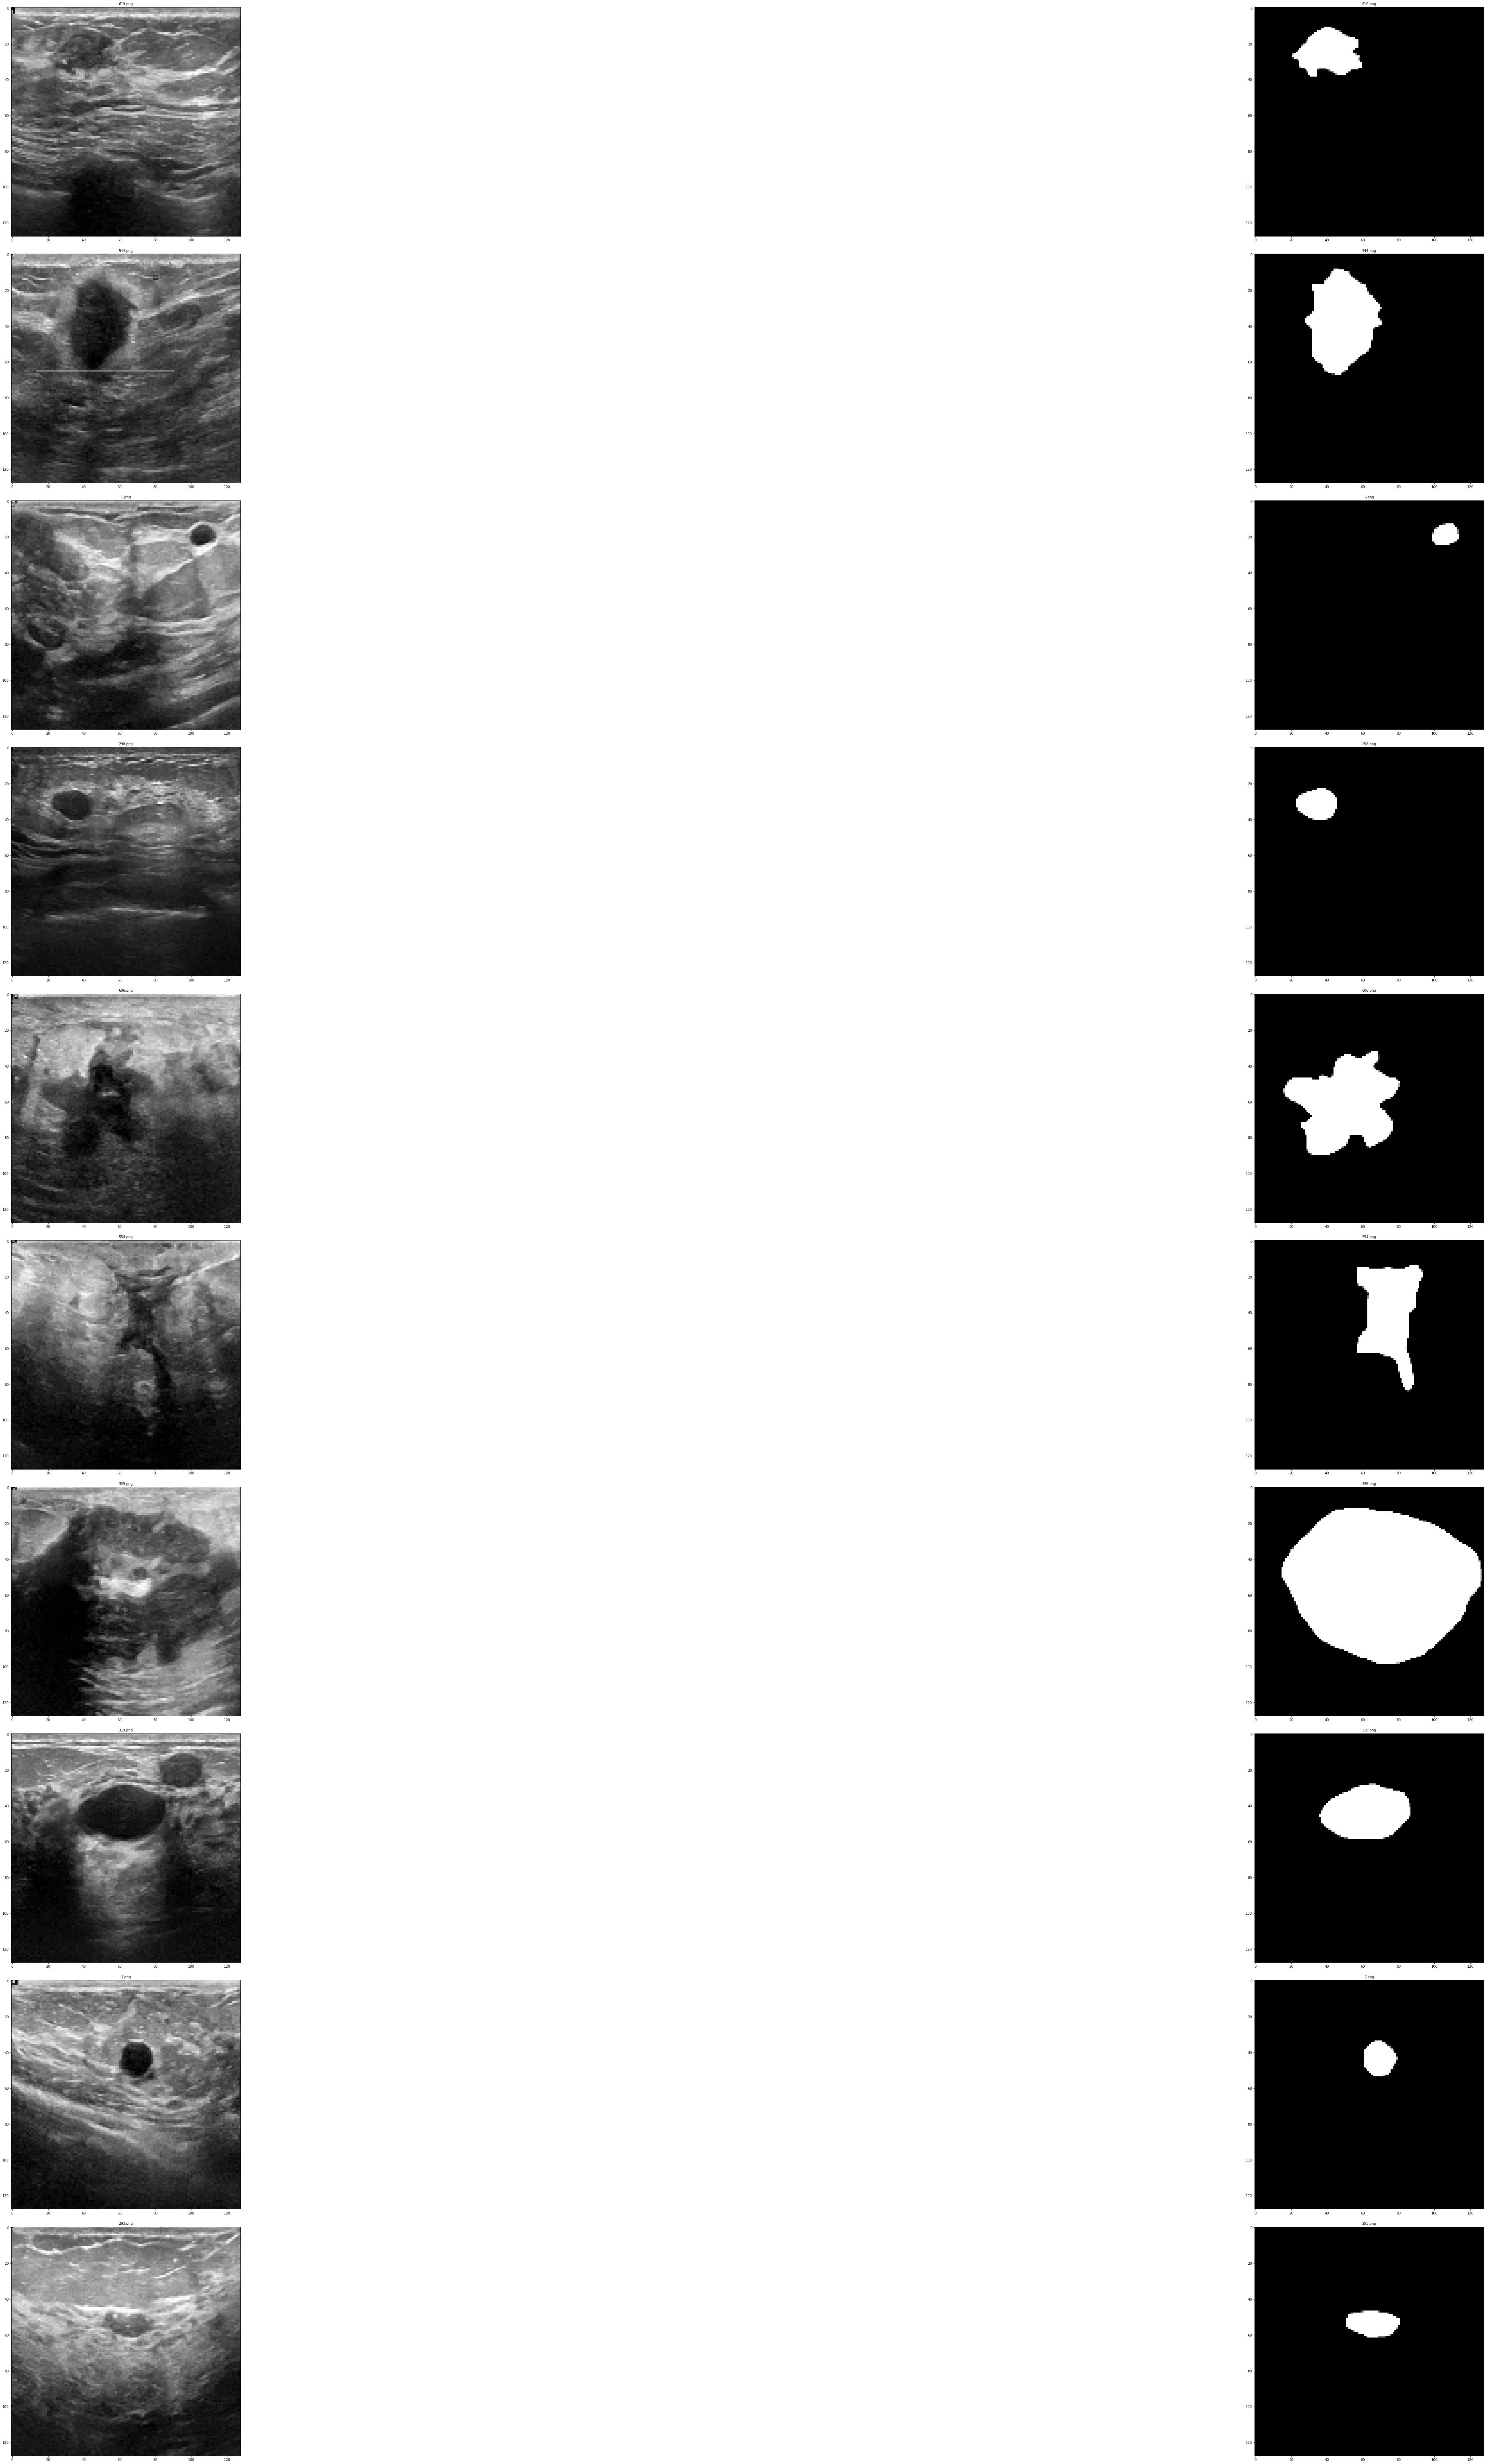

In [ ]:
#visualize first 10 elems in trainloader batch
f, axis = plt.subplots(nrows=10, ncols=2, constrained_layout=True, figsize=(100, 100))

for i in range(10):

  axis[i,0].set_title(v[2][i], fontsize='medium')
  axis[i,0].imshow(v[0][i].squeeze() *255, cmap='gray')
  axis[i,1].set_title(v[2][i],fontsize='medium')
  axis[i,1].imshow(v[1][i].squeeze() *255, cmap='gray')

plt.show()

**Model**

In [ ]:
!pip install  segmentation_models_pytorch 
import segmentation_models_pytorch as smp


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 7.0 MB/s 
     |████████████████████████████████| 376 kB 60.5 MB/s 
     |████████████████████████████████| 58 kB 7.8 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=c4b6fd86a33f10fbf16631c7fd586d507c8c095ef8ff9d115f674bea58a9c65b
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=e9d338cf6327c3378761e76d92b8c82d205dca32ac1f30e810cf490ad1152caf
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


UNet++ with ResNet backbone

In [ ]:
#UNet++ model with ResNet34 Backbone
class UNetPP(nn.Module):
  def __init__(self, name):
     super(UNetPP,self).__init__()
     self.net = smp.UnetPlusPlus(encoder_name='resnet34', 
                  encoder_depth=5, 
                  encoder_weights='imagenet', 
                  decoder_use_batchnorm=True, 
                  decoder_channels=(256, 128, 64, 32, 16), 
                  decoder_attention_type=None, 
                  in_channels=1, 
                  classes=1, 
                  activation=None, 
                  aux_params=None)
     self.name = name
  def forward(self, x):
    return self.net(x)

SK-U-Net

In [ ]:
class SKBlock(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(SKBlock, self).__init__()
    self.out_ch = out_ch
    self.dilated_conv_path = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=2,dilation=2),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
    )
    self.attention_layer =  nn.Sequential(
            nn.Linear(out_ch, int(out_ch * 0.5)),
            nn.BatchNorm1d(int(out_ch * 0.5)),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(int(out_ch * 0.5),out_ch),
            nn.Sigmoid(),
    )

  def forward(self, x):
    x1 = self.dilated_conv_path(x)
    x2 = self.conv(x)

    x3 = x1 + x2
    size_per_channel = x3.shape[-1]
    x3 = nn.AvgPool2d(size_per_channel)(x3)
    x3 = x3.mean(3)
    x3 = x3.mean(2)
    
    x3 = self.attention_layer(x3)
   
    x4 = 1-x3
    x3 = torch.reshape(x3,(x1.shape[0],x1.shape[1] ,1,1))
    x4 = torch.reshape(x4,(x2.shape[0],x2.shape[1],1,1))
 

    x1 = torch.mul(x1,x3)
    x2 =  torch.mul(x2,x4)
    return x1 + x2

In [ ]:

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up_scale = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
         

    def forward(self, x1, x2):
        x2 = self.up_scale(x2)

        diffY = x1.size()[2] - x2.size()[2]
        diffX = x1.size()[3] - x2.size()[3]

        x2 = F.pad(x2, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return x


class down_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down_layer, self).__init__()
        self.pool = nn.AvgPool2d(2, stride=2, padding=0)
        self.conv = SKBlock(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(self.pool(x))
        return x


class up_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_layer, self).__init__()
        self.up = up(in_ch, out_ch)
        
        self.conv = SKBlock(in_ch, out_ch)

    def forward(self, x1, x2):
        a = self.up(x1, x2)

        x = self.conv(a)
        return x

In [ ]:
class SKUNet(nn.Module):
    def __init__(self, name):
        super(SKUNet, self).__init__()
        self.name = name

        self.conv1 = SKBlock(1, 8)
        self.down1 = down_layer(8, 16)
        self.down2 = down_layer(16, 32)
        self.down3 = down_layer(32, 64)
        self.down4 = down_layer(64, 128)
        self.down5 = down_layer(128, 256)
        self.down6 = down_layer(256, 512)
        self.down7 = down_layer(512, 1024)
        
        self.up1 = up_layer(1024, 512)
        # self.attention1 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.up2 = up_layer(512, 256)
        # self.attention2 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.up3 = up_layer(256, 128)
        # self.attention3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.up4 = up_layer(128, 64)
        # self.attention4 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.up5 = up_layer(64, 32)
        self.up6 = up_layer(32, 16)
        self.up7 = up_layer(16, 8)
        self.last_conv = nn.Conv2d(8, 1, 1)
        self.dilute = nn.Conv2d(1, 1, 1)


    def forward(self, x):
        x1 = self.conv1(x)
        #print(x1.shape)
        x2 = self.down1(x1)
        #print(x2.shape)

        x3 = self.down2(x2)
        #print(x3.shape)
        x4 = self.down3(x3)
        #print(x4.shape)
        x5 = self.down4(x4)
        #print(x5.shape)
        x6 = self.down5(x5)
        #print(x6.shape)
        x7 = self.down6(x6)
       # print(x7.shape)
        x8 = self.down7(x7)
        #print(x8.shape)
        
        x1_up = self.up1(x7, x8)
       # print(x1_up.shape)
        x2_up = self.up2(x6, x1_up)
        #print(x2_up.shape)
        x3_up = self.up3(x5, x2_up)
        #print(x3_up.shape)
        x4_up = self.up4(x4, x3_up)
        #print(x4_up.shape)
        x5_up = self.up5(x3, x4_up)
        #print(x5_up.shape)
        x6_up = self.up6(x2, x5_up)
        #print(x6_up.shape) 
        x7_up = self.up7(x1, x6_up)
        #print(x7_up.shape)
    
        output = self.last_conv(x7_up)
        output = self.dilute(output)
        #output = torch.sigmoid(output)
        return output

SK-U-Net with ResNet Encoder

In [ ]:
class SKBlock(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(SKBlock, self).__init__()
    self.out_ch = out_ch
    self.dilated_conv_path = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=2,dilation=2),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
    )
    self.attention_layer =  nn.Sequential(
            nn.Linear(out_ch, int(out_ch * 0.5)),
            nn.BatchNorm1d(int(out_ch * 0.5)),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(int(out_ch * 0.5),out_ch),
            nn.Sigmoid(),
    )

  def forward(self, x):
    x1 = self.dilated_conv_path(x)
    x2 = self.conv(x)
    # print(x1.shape)
    # print(x2.shape)
    x3 = x1 + x2
    size_per_channel = x3.shape[-1]
    x3 = nn.AvgPool2d(size_per_channel)(x3)
    x3 = x3.mean(3)
    x3 = x3.mean(2)
    # print(x3.shape)
    x3 = self.attention_layer(x3)
    # x3 = self.a(x3)
    # print('a')
    # x3 = self.b(x3)
    # x3
    # print(x3.shape)
    x4 = 1-x3
    x3 = torch.reshape(x3,(x1.shape[0],x1.shape[1] ,1,1))
    x4 = torch.reshape(x4,(x2.shape[0],x2.shape[1],1,1))
    # print(x1.shape)
    # print(x3.shape)

    x1 = torch.mul(x1,x3)
    x2 =  torch.mul(x2,x4)
    return x1 + x2

In [ ]:

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up_scale = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
         

    def forward(self, x1, x2):
        x2 = self.up_scale(x2)

        diffY = x1.size()[2] - x2.size()[2]
        diffX = x1.size()[3] - x2.size()[3]

        x2 = F.pad(x2, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return x


class down_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down_layer, self).__init__()
        self.pool = nn.AvgPool2d(2, stride=2, padding=0)
        self.conv = SKBlock(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(self.pool(x))
        return x


class up_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_layer, self).__init__()
        self.up = up(in_ch, out_ch)
        
        self.conv = SKBlock(in_ch, out_ch)

    def forward(self, x1, x2):
        a = self.up(x1, x2)

        x = self.conv(a)
        return x
      
class up_layer4(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_layer4, self).__init__()
        self.up = up(in_ch, out_ch)
        
        self.conv = SKBlock(96, out_ch)

    def forward(self, x1, x2):
        a = self.up(x1, x2)
        # print("success usample")
        # print(a.shape)

        x = self.conv(a)
        # print("success conv")
        return x
        
class up_layer5(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_layer5, self).__init__()
        self.up = up(in_ch, out_ch)
        
        self.conv = SKBlock(17, out_ch)

    def forward(self, x1, x2):
        a = self.up(x1, x2)
        # print("success usample")
        # print(a.shape)

        x = self.conv(a)
        # print("success conv")
        return x

In [ ]:
class SKUNet(nn.Module):
    def __init__(self, name):
        super(SKUNet, self).__init__()
        self.name = name

        
        m = smp.UnetPlusPlus(encoder_name='resnet34', 
                  encoder_depth=5, 
                  encoder_weights='imagenet', 
                  decoder_use_batchnorm=True, 
                  decoder_channels=(256, 128, 64, 32, 16), 
                  decoder_attention_type=None, 
                  in_channels=1, 
                  classes=1, 
                  activation=None, 
                  aux_params=None)
        self.encoder = m.encoder
        
        self.up1 = up_layer(512, 256)
        # self.attention1 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.up2 = up_layer(256,128)
        # self.attention2 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.up3 = up_layer(128, 64)
        # self.attention3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.up4 = up_layer4(64, 32)
        # self.attention4 = Attention_block(F_g=64,F_l=64,F_int=32)


        self.up5 = up_layer5(32, 16)
        


        self.last_conv = nn.Conv2d(16, 1, 1)
        self.dilute = nn.Conv2d(1, 1, 1)


    def forward(self, x):
    ]
    
        x1,x2,x3,x4,x5,x6 = self.encoder(x)
        
        x1_up = self.up1(x5, x6)
      
        x2_up = self.up2(x4, x1_up)
       
        x3_up = self.up3(x3, x2_up)
        
        x4_up = self.up4(x2, x3_up)
        

        x5_up = self.up5(x1, x4_up)
    
        output = self.last_conv(x5_up)
        output = self.dilute(output)
        #output = torch.sigmoid(output)
        return output

U-Net

In [ ]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up_scale = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        # self.attention = Attention_block(F_g=out_ch,F_l=out_ch,F_int=out_ch//2) #needs to be an integer! so integer division
         

    def forward(self, x1, x2):
        x2 = self.up_scale(x2)
        # x1 = self.attention(g=x2, x=x1)

        diffY = x1.size()[2] - x2.size()[2]
        diffX = x1.size()[3] - x2.size()[3]

        x2 = F.pad(x2, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return x


class down_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down_layer, self).__init__()
        self.pool = nn.AvgPool2d(2, stride=2, padding=0)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(self.pool(x))
        return x


class up_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_layer, self).__init__()
        self.up = up(in_ch, out_ch)
        
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        a = self.up(x1, x2)

        x = self.conv(a)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, name):
        super(UNet, self).__init__()
        self.name = name

        self.conv1 = double_conv(1, 8)
        self.down1 = down_layer(8, 16)
        self.down2 = down_layer(16, 32)
        self.down3 = down_layer(32, 64)
        self.down4 = down_layer(64, 128)
        self.down5 = down_layer(128, 256)
        self.down6 = down_layer(256, 512)
        self.down7 = down_layer(512, 1024)
        
        self.up1 = up_layer(1024, 512)
        # self.attention1 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.up2 = up_layer(512, 256)
        # self.attention2 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.up3 = up_layer(256, 128)
        # self.attention3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.up4 = up_layer(128, 64)
        # self.attention4 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.up5 = up_layer(64, 32)
        self.up6 = up_layer(32, 16)
        self.up7 = up_layer(16, 8)
        self.last_conv = nn.Conv2d(8, 1, 1)
        self.dilute = nn.Conv2d(1, 1, 1)


    def forward(self, x):
        x1 = self.conv1(x)
        #print(x1.shape)
        x2 = self.down1(x1)
        #print(x2.shape)

        x3 = self.down2(x2)
        #print(x3.shape)
        x4 = self.down3(x3)
        #print(x4.shape)
        x5 = self.down4(x4)
        #print(x5.shape)
        x6 = self.down5(x5)
        #print(x6.shape)
        x7 = self.down6(x6)
       # print(x7.shape)
        x8 = self.down7(x7)
        #print(x8.shape)
        
        x1_up = self.up1(x7, x8)
       # print(x1_up.shape)
        x2_up = self.up2(x6, x1_up)
        #print(x2_up.shape)
        x3_up = self.up3(x5, x2_up)
        #print(x3_up.shape)
        x4_up = self.up4(x4, x3_up)
        #print(x4_up.shape)
        x5_up = self.up5(x3, x4_up)
        #print(x5_up.shape)
        x6_up = self.up6(x2, x5_up)
        #print(x6_up.shape) 
        x7_up = self.up7(x1, x6_up)
        #print(x7_up.shape)
    
        output = self.last_conv(x7_up)
        output = self.dilute(output)
        #output = torch.sigmoid(output)
        return output

Test if the model has errors by passing in a dummy input tensor


In [ ]:
#test if the model has errors by passing in a dummy input tensor
z = torch.randn(16,1,224,224)
m = UNetPP("dummy")
m.eval()
m(z).shape


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

torch.Size([16, 1, 224, 224])

Loss

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):    
        
        #flatten label and prediction tensors
        inputs = torch.sigmoid(inputs) #WITH LOGITS
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

Train Loop

In [ ]:
#kept this method, as it helps with experiment tracking
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
def train_net(net, train_dset, valid_dset, device, batch_size=64, learning_rate=1.0E-3, num_epochs=30):
    """ Trains the network on  train_dset and measures performance on valid_set.

     Args:
         net: PyTorch neural network object
         train_dset: PyTorch training dataset
         vald_dset: Pytorch validation dataset
         device: the acceleration device (GPU or CPU)
         batch_size: the batch size (default 64)
         learning_rate: the learning rate (default 0.001)
         num_epochs: the total number of epochs over which to train (default 30)
     Returns:
         the model name (using get_model_name) of the epoch with the lowest validation loss (to get a rough idea of when the model starts overfitting )
     """
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = DataLoader(dataset=train_dset, shuffle=True, batch_size=batch_size, num_workers=4)
    val_loader = DataLoader(dataset=valid_dset, shuffle=False, batch_size=1, num_workers=4)
    ########################################################################
   
    criterion = DiceLoss() #Dice Loss
    criterion2 = smp.losses.SoftBCEWithLogitsLoss() #Binary Cross entropy loss with logits for image segmentation
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2) #vary learning rate using cosine to converge to better optimum by samping more learning rates

    ########################################################################
    # Set up some numpy arrays to store the training/validation loss/accuracy
  
    train_loss = np.zeros(num_epochs)
   
    val_loss = np.zeros(num_epochs)
    #initializing variables to track best epoch (for my convenience later when choosing a model to get an idea of roughly when the model starts overfitting)
     
    best_epoch = 0
    best_epoch_val_loss = 0 

    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_valid_loss = 0.0
        total_epoch = 0
        net.train()
        # print("in train loop")
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data[0], data[1]
            # print(inputs.shape)
             #To Enable GPU Usage (if GPU available, otherwise device = CPU)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels) + 0.5* criterion2(outputs,labels) #Hybrid loss function
            loss.backward()
            optimizer.step()
        
            
            
            # Calculate the statistics
           
            total_train_loss += loss.item()
            total_epoch += len(labels)
        
        if epoch >= 30:
          lr_scheduler.step() #only begin cosine  learning rate adjustment midway through training (the model validation loss was observed to decrease slower here, hence why we start varying LR)
        train_loss[epoch] = float(total_train_loss) / (i+1) #avg training loss
        current_lr = optimizer.state_dict()['param_groups'][0]['lr']
        net.eval()
        with torch.no_grad():
          for i, data in enumerate(val_loader, 0):
              # Get the inputs
              inputs, labels = data[0], data[1]
              #To Enable GPU Usage (if GPU available, otherwise device = CPU)
              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = net(inputs)
          
              loss = criterion(outputs, labels)
              
              total_valid_loss += loss.item()
          val_loss[epoch] = float(total_valid_loss) / (i+1) #avg validation loss
        
        if epoch == 0: #if first epoch, initialize tracker values
          best_epoch = epoch
          best_epoch_val_loss = val_loss[epoch]


        elif val_loss[epoch] < best_epoch_val_loss: #change to track the epoch with lowest validation loss
          best_epoch_val_loss = val_loss[epoch]
          best_epoch = epoch
        print(("Epoch {}: , Train Loss: {} |"+
               "Validation DiceLoss: {} | lr: {}").format(
                   epoch + 1,
                   train_loss[epoch],
                   val_loss[epoch],
                   current_lr))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    print("Best Epoch Was: ", best_epoch)
    print("Best Epoch Loss: ", best_epoch_val_loss)
    
    #plot training curve
    plt.title("Train vs Validation Loss")
    n = len(train_loss) # number of epochs
    plt.plot(range(1,n+1), train_loss, label="Train (HybridLoss)")
    plt.plot(range(1,n+1), val_loss, label="Validation (DiceLoss)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    return get_model_name(net.name, batch_size, learning_rate, best_epoch)

**Training**

In [ ]:
from numba import cuda 

if torch.cuda.is_available():
  device = cuda.get_current_device()
  device.reset()


is_cuda = torch.cuda.is_available()

# Use GPU if available. device vairable will also be used later in the code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")


GPU is available


Example: training UNet++ on fold 1

In [ ]:
model = UNetPP(name="UNetPP_fold1")
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

UNetPP(
  (net): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Ba

In [ ]:
#freezing backbone layers for transer learning (only for the models using transfer learning)
for k,v in model.named_parameters():
    # print(k)
    # print(v.requires_grad)
    if("bn" in k):
      v.requires_grad= True
    elif ("encoder" in k):
      v.requires_grad = False

In [ ]:
for k,v in model.named_parameters():
    print(k)
    print(v.requires_grad)

net.encoder.conv1.weight
False
net.encoder.bn1.weight
True
net.encoder.bn1.bias
True
net.encoder.layer1.0.conv1.weight
False
net.encoder.layer1.0.bn1.weight
True
net.encoder.layer1.0.bn1.bias
True
net.encoder.layer1.0.conv2.weight
False
net.encoder.layer1.0.bn2.weight
True
net.encoder.layer1.0.bn2.bias
True
net.encoder.layer1.1.conv1.weight
False
net.encoder.layer1.1.bn1.weight
True
net.encoder.layer1.1.bn1.bias
True
net.encoder.layer1.1.conv2.weight
False
net.encoder.layer1.1.bn2.weight
True
net.encoder.layer1.1.bn2.bias
True
net.encoder.layer1.2.conv1.weight
False
net.encoder.layer1.2.bn1.weight
True
net.encoder.layer1.2.bn1.bias
True
net.encoder.layer1.2.conv2.weight
False
net.encoder.layer1.2.bn2.weight
True
net.encoder.layer1.2.bn2.bias
True
net.encoder.layer2.0.conv1.weight
False
net.encoder.layer2.0.bn1.weight
True
net.encoder.layer2.0.bn1.bias
True
net.encoder.layer2.0.conv2.weight
False
net.encoder.layer2.0.bn2.weight
True
net.encoder.layer2.0.bn2.bias
True
net.encoder.layer2.

Epoch 1: , Train Loss: 0.5576000836205809 |Validation DiceLoss: 0.3335642976354259 | lr: 0.001
Epoch 2: , Train Loss: 0.36291630515088774 |Validation DiceLoss: 0.3166559680487758 | lr: 0.001
Epoch 3: , Train Loss: 0.3115525241583994 |Validation DiceLoss: 0.2931309730507607 | lr: 0.001
Epoch 4: , Train Loss: 0.28573308803447306 |Validation DiceLoss: 0.3055976620016172 | lr: 0.001
Epoch 5: , Train Loss: 0.2605383263467109 |Validation DiceLoss: 0.2634079701216646 | lr: 0.001
Epoch 6: , Train Loss: 0.24559622707024012 |Validation DiceLoss: 0.2810165974520898 | lr: 0.001
Epoch 7: , Train Loss: 0.2387856171555715 |Validation DiceLoss: 0.2647867900456569 | lr: 0.001
Epoch 8: , Train Loss: 0.22289827379257712 |Validation DiceLoss: 0.27812201939812004 | lr: 0.001
Epoch 9: , Train Loss: 0.20936368242518544 |Validation DiceLoss: 0.25367930647014647 | lr: 0.001
Epoch 10: , Train Loss: 0.20440167607101675 |Validation DiceLoss: 0.2605283440545548 | lr: 0.001
Epoch 11: , Train Loss: 0.193251357707258

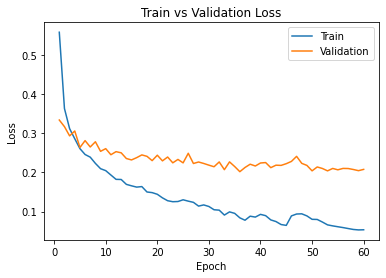

'model_UNetPP_224imgsize_combinedloss2_transferlearning_bs16_lr0.001_epoch35'

In [ ]:
train_net(model, train_dset, valid_dset, device, batch_size=16, learning_rate=1.0E-3, num_epochs=60)